# Tutorial: events in data classes

**Author:** Masoud Abedinifar

**Last update:** Tue 08 Feb 2024

## Learning objectives
By the end of this tutorial:
- Load data from a recording that belongs to one of the available datasets.
- Store events from algorithms in the datclass per recording file.
- Visualize events in data

## Import libraries
The necessary libraries such as numpy, matplotlib.pyplot, dataset (mobilised), Paraschiv-Ionescu gait sequence detection, and Paraschiv-Ionescu initial contact detection algorithms are imported from their corresponding modules. Make sure that you have all the required libraries and modules installed before running this code. You also may need to install the 'ngmt' library and its dependencies if you haven't already.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ngmt.datasets import mobilised
from ngmt.modules.gsd import ParaschivIonescuGaitSequenceDetection
from ngmt.modules.icd import ParaschivIonescuInitialContactDetection
from ngmt.config import cfg_colors

First load the data and put in the desired dataclasses.

In [3]:
# The 'file_path' variable holds the absolute path to the data file
file_path = (
    r"C:\Users\Project\Desktop\Gait_Sequence\Mobilise-D dataset_1-18-2023\CHF\data.mat"
)

# In this example, we use "SU" as tracking_system and "LowerBack" as tracked points.
tracking_sys = "SU"
tracked_points = {tracking_sys: ["LowerBack"]}

# The 'mobilised.load_recording' function is used to load the data from the specified file_path
recording = mobilised.load_recording(
    file_name=file_path, tracking_systems=[tracking_sys], tracked_points=tracked_points
)

# Print recording data
print(f"Recording: {recording}")

Recording: NGMTRecording(data={'SU':         LowerBack_ACCEL_x  LowerBack_ACCEL_y  LowerBack_ACCEL_z  \
0                0.969647          -0.033464          -0.001778   
1                0.970406          -0.036270          -0.000252   
2                0.973402          -0.040885           0.000498   
3                0.972774          -0.038731           0.005013   
4                0.974063          -0.036836          -0.001207   
...                   ...                ...                ...   
825257           0.955821           0.125987          -0.138808   
825258           0.959240           0.122561          -0.133614   
825259           0.962769           0.123223          -0.132914   
825260           0.961867           0.120815          -0.132230   
825261           0.958991           0.120482          -0.129221   

        LowerBack_GYRO_x  LowerBack_GYRO_y  LowerBack_GYRO_z  \
0               0.428000          0.016900          0.074600   
1               0.569697      

In [4]:
# Iterate over the keys in the recording data dictionary
for key in recording.data.keys():
    print(
        f"name: {key}, shape: {recording.data[key].shape}, \n\tcolumns: {recording.data[key].columns}"
    )

name: SU, shape: (825262, 10), 
	columns: Index(['LowerBack_ACCEL_x', 'LowerBack_ACCEL_y', 'LowerBack_ACCEL_z',
       'LowerBack_GYRO_x', 'LowerBack_GYRO_y', 'LowerBack_GYRO_z',
       'LowerBack_MAGN_x', 'LowerBack_MAGN_y', 'LowerBack_MAGN_z',
       'LowerBack_BARO_n/a'],
      dtype='object')


In [5]:
# Load lower back acceleration data
acceleration_data = recording.data[tracking_sys][
    ["LowerBack_ACCEL_x", "LowerBack_ACCEL_y", "LowerBack_ACCEL_z"]
]
print(f"Acceleration data: {acceleration_data}")

Acceleration data:         LowerBack_ACCEL_x  LowerBack_ACCEL_y  LowerBack_ACCEL_z
0                0.969647          -0.033464          -0.001778
1                0.970406          -0.036270          -0.000252
2                0.973402          -0.040885           0.000498
3                0.972774          -0.038731           0.005013
4                0.974063          -0.036836          -0.001207
...                   ...                ...                ...
825257           0.955821           0.125987          -0.138808
825258           0.959240           0.122561          -0.133614
825259           0.962769           0.123223          -0.132914
825260           0.961867           0.120815          -0.132230
825261           0.958991           0.120482          -0.129221

[825262 rows x 3 columns]


In [6]:
# Get the corresponding sampling frequency directly from the recording
sampling_frequency = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"] == "LowerBack_ACCEL_x"
]["sampling_frequency"].values[0]
print(f"Sampling frequency: {sampling_frequency} Hz")

Sampling frequency: 100.0 Hz


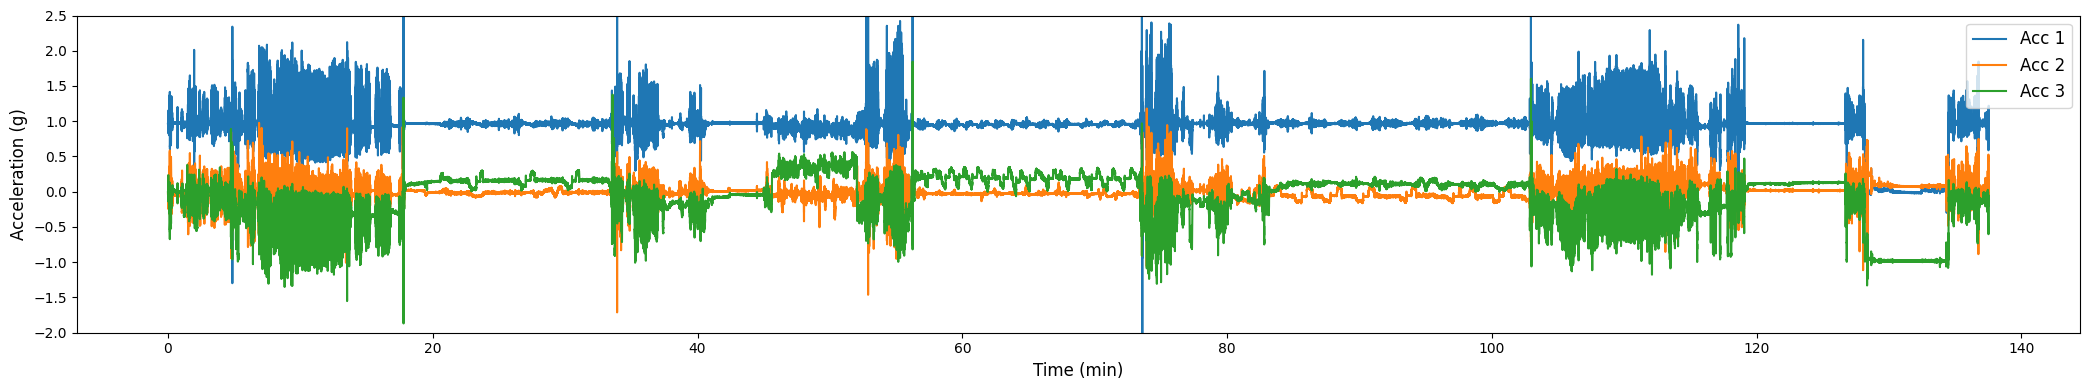

In [33]:
# Plot acceleration data against time
fig, ax = plt.subplots(figsize=(21, 4))

for i in range(3):
    ax.plot(
        np.arange(len(acceleration_data)) / sampling_frequency / 60,
        acceleration_data[f"LowerBack_ACCEL_{chr(120 + i)}"],
        label=f"Acc {i + 1}",
    )
ax.set_ylabel(f"Acceleration (g)", fontsize=12)
ax.set_xlabel(f"Time (min)", fontsize=12)
ax.legend(loc="upper right", fontsize=12)
ax.set_ylim(-2, 2.5)
plt.tight_layout()
plt.show()

The events are put into a pandas DataFrame, and follow the conventions outlined in the BIDS documentation (i.e. https://bids-specification.readthedocs.io/en/stable/modality-specific-files/task-events.html).

### Gait sequence events in dataclass

In [8]:
# Create an instance of the ParaschivIonescuGaitSequenceDetection class
gsd = ParaschivIonescuGaitSequenceDetection(target_sampling_freq_Hz=40)

# Call the gait sequence detection using gsd.detect to detect gait sequences
gsd = gsd.detect(
    data=acceleration_data, sampling_freq_Hz=sampling_frequency, plot_results=False
)

86 gait sequence(s) detected.


In [9]:
# Add events to the recording as a dictionary including tracking system and events
gait_sequence_events = gsd.gait_sequences_
recording.add_events(tracking_system=tracking_sys, new_events=gait_sequence_events)
print(f"events: {recording.events}")

events: {'SU':        onset  duration     event_type tracking_systems tracked_points
0      4.500     5.250  gait sequence               SU      LowerBack
1     90.225    10.300  gait sequence               SU      LowerBack
2    106.075     5.600  gait sequence               SU      LowerBack
3    116.225    10.350  gait sequence               SU      LowerBack
4    141.275     5.850  gait sequence               SU      LowerBack
..       ...       ...            ...              ...            ...
81  7617.150     4.150  gait sequence               SU      LowerBack
82  7679.425    10.625  gait sequence               SU      LowerBack
83  8090.625     4.200  gait sequence               SU      LowerBack
84  8149.850     5.050  gait sequence               SU      LowerBack
85  8184.875    21.450  gait sequence               SU      LowerBack

[86 rows x 5 columns]}


### Initial contact events in dataclass

In [10]:
# Now, use Paraschiv-Ionescu initial contact detection algortihm to find initial contacts within detected gait sequences.
icd = ParaschivIonescuInitialContactDetection(target_sampling_freq_Hz=40)

# Call the initial contact detection using icd.detect
icd = icd.detect(
    data=acceleration_data,
    gait_sequences=gsd.gait_sequences_,
    sampling_freq_Hz=sampling_frequency,
)

In [11]:
# Add events to the recording as a dictionary including tracking system and events
initial_contacts_events = icd.initial_contacts_

recording.add_events(tracking_system=tracking_sys, new_events=initial_contacts_events)

# Print events types including both detected gait sequences and initial contacts
print(f"events: {recording.events}")

events: {'SU':          onset  duration       event_type tracking_systems tracked_points
0        4.500      5.25    gait sequence               SU      LowerBack
1       90.225     10.30    gait sequence               SU      LowerBack
2      106.075      5.60    gait sequence               SU      LowerBack
3      116.225     10.35    gait sequence               SU      LowerBack
4      141.275      5.85    gait sequence               SU      LowerBack
...        ...       ...              ...              ...            ...
3533  8203.200       NaN  initial contact               SU      LowerBack
3534  8203.675       NaN  initial contact               SU      LowerBack
3535  8204.325       NaN  initial contact               SU      LowerBack
3536  8205.425       NaN  initial contact               SU      LowerBack
3537  8206.100       NaN  initial contact               SU      LowerBack

[3538 rows x 5 columns]}


Plot the data and gait sequence events and initial contact events in different colors.

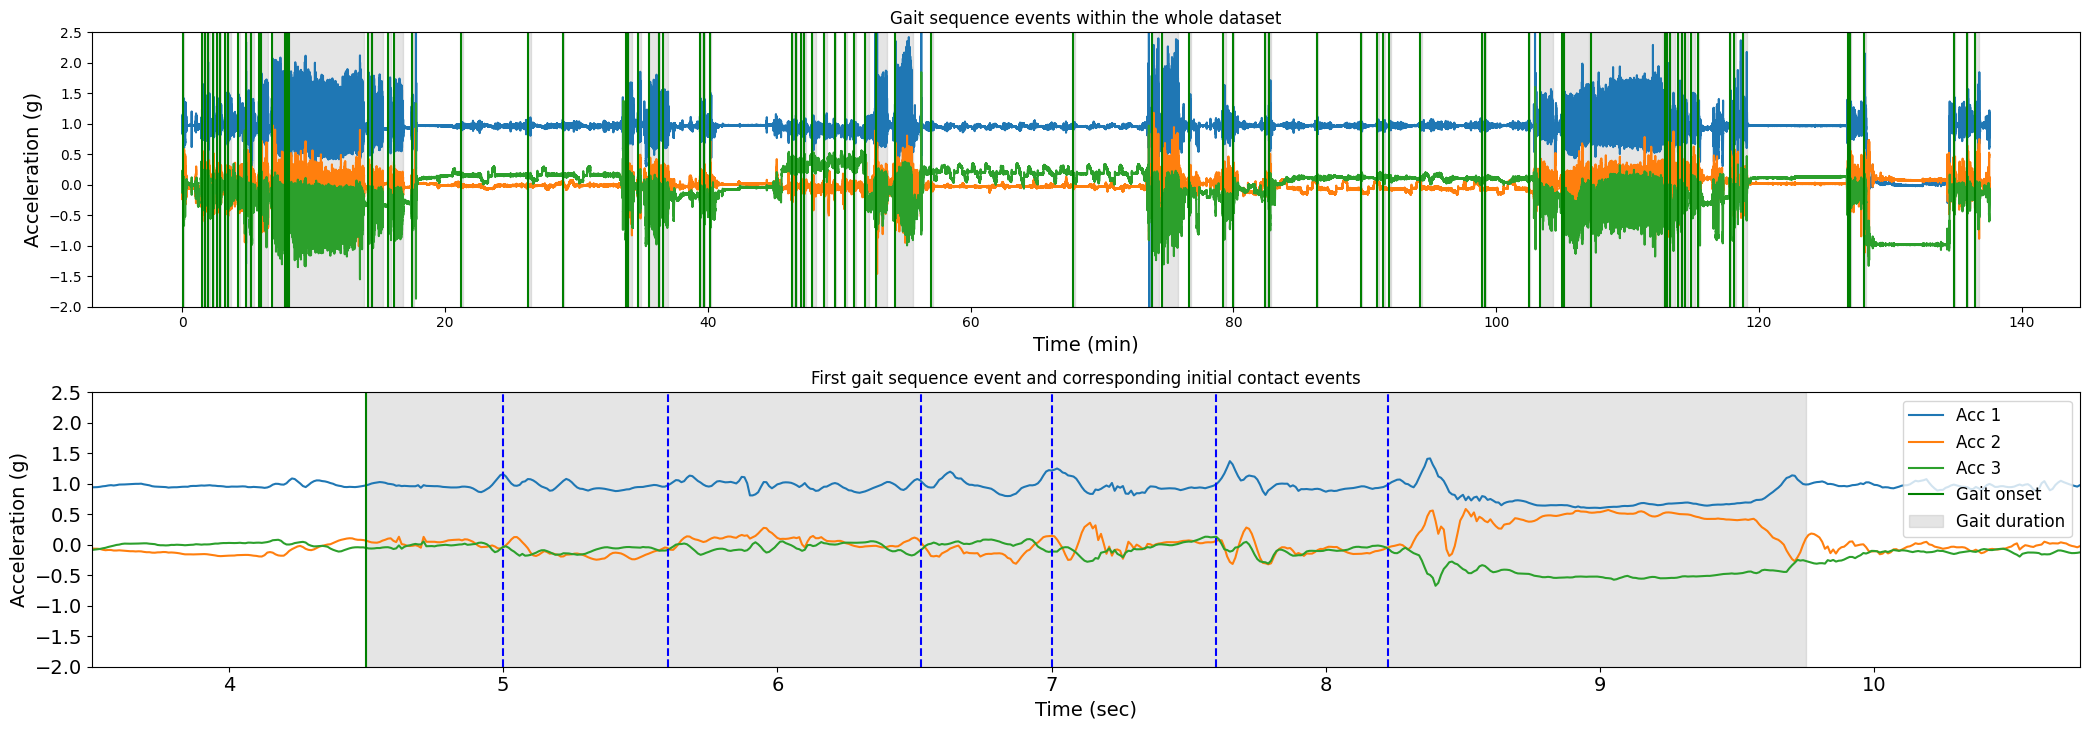

In [26]:
# Access to all gait sequences
all_gait_sequences = recording.events[tracking_sys][recording.events[tracking_sys]["event_type"] == "gait sequence"]

# Subplot 1
fig, axs = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(21, 7.4))

# Plot all gait sequences in the first subplot
axs[0].plot(np.arange(len(acceleration_data)) / sampling_frequency / 60, acceleration_data)
for index, gait_sequence in all_gait_sequences.iterrows():
    onset = gait_sequence["onset"] / 60
    duration = gait_sequence["duration"] / 60
    axs[0].axvline(onset, color="green")
    axs[0].axvspan(onset, onset + duration, alpha=0.2, color="gray")

axs[0].set_title("Gait sequence events within the whole dataset")
axs[0].set_xlabel("Time (min)", fontsize=14)
axs[0].set_ylabel("Acceleration (g)", fontsize=14)
axs[0].set_ylim(-2, 2.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Subplot 2
# Access to the detected first gait sequences
first_gait_sequence = recording.events[tracking_sys].iloc[0]

# Initial contacts within the first gait sequence
ic_within_first_gs = initial_contacts_events[
    initial_contacts_events["onset"].between(
        first_gait_sequence["onset"],
        first_gait_sequence["onset"] + first_gait_sequence["duration"],
    )
]

# Calculate the time values based on the length of the data
num_samples = len(acceleration_data)
time_seconds = np.arange(num_samples) / sampling_frequency

for i in range(3):
    axs[1].plot(
        time_seconds,
        acceleration_data[f"LowerBack_ACCEL_{chr(120 + i)}"],
        label=f"Acc {i + 1}",
    )

# Plot the first element of gait sequences
axs[1].axvline(first_gait_sequence["onset"], color="g", label="Gait onset")
axs[1].axvspan(
    first_gait_sequence["onset"],
    first_gait_sequence["onset"] + first_gait_sequence["duration"],
    alpha=0.2,
    color="gray",
    label="Gait duration",
)

# Plot the initial contacts within first gait sequences
for ic_time in ic_within_first_gs["onset"]:
    axs[1].axvline(ic_time, color="blue", linestyle="--")

# Customize plot
axs[1].set_title("First gait sequence event and corresponding initial contact events")
axs[1].set_ylim(-2, 2.5)
axs[1].set_xlabel("Time (sec)", fontsize=14)
axs[1].set_ylabel("Acceleration (g)", fontsize=14)
axs[1].legend(loc="upper right", fontsize=12)
start_limit = first_gait_sequence["onset"] - 1
end_limit = first_gait_sequence["onset"] + first_gait_sequence["duration"] + 1
axs[1].set_xlim(start_limit, end_limit)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()